In [1]:
nevecs = 50
ncomps = 500
nbasecomps = 25
crop_size=180
ncauses = 2
dr_method = 'PCA'

In [2]:
from pathlib import Path
import os, sys
import torchvision.transforms.functional as F
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

In [3]:

macaw_path = Path(os.getcwd())
sys.path.append(str(macaw_path) +'/')

exp_name = 'moin_bias'

train_csv_path = macaw_path/'splits2/exp199/train.csv'
train_img_path = macaw_path/exp_name/'train'

val_csv_path = macaw_path/'splits2/exp199/val.csv'
val_img_path = macaw_path/exp_name/'val'

pca_path = macaw_path/exp_name/f'train_hc_pca_{ncomps}.pkl'

train_path = macaw_path/exp_name/f'train_hc_data_{dr_method}_{ncomps}.pkl'
val_path = macaw_path/exp_name/f'val_hc_data_{dr_method}_{ncomps}.pkl'
model_base_path = macaw_path/'models'/exp_name/f'{dr_method}_{ncomps}'/f'{nevecs}'

if not os.path.exists(model_base_path):
    os.makedirs(model_base_path)

In [4]:
import pickle

with open(train_path, 'rb') as f:
    train = pickle.load(f)
    
disease_t = train['disease']
bias_t = train['bias']

encoded_t = train['encoded_data']
pca_t = train['pca']

In [5]:
with open(val_path, 'rb') as f:
    val = pickle.load(f)
    
disease_v = val['disease']
bias_v = val['bias']

encoded_v = val['encoded_data']
pca_v = val['pca']

## Causal Graph

In [6]:
disease_to_latents = [(0,i) for i in range(ncauses,nevecs+ncauses)]
bias_to_latents = [(1,i) for i in range(ncauses,nevecs+ncauses)]

autoregressive_latents = [(i,j) for i in range(ncauses,nevecs+ncauses) for j in range(i+1,nevecs+ncauses)]
edges = disease_to_latents + bias_to_latents + autoregressive_latents

## Priors

In [7]:
P_bias = np.sum(bias_t)/len(bias_t)
print(P_bias)

P_dis = np.sum(disease_t)/len(disease_t)
print(P_dis)

0.620633631194151
0.5418359057676686


In [8]:
import torch
import yaml
from utils.helpers import dict2namespace

with open(macaw_path/'config'/'ukbb.yaml', 'r') as f:
    config_raw = yaml.load(f, Loader=yaml.FullLoader)
    
config = dict2namespace(config_raw)
config.device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

In [9]:
config.device

device(type='cuda')

In [10]:
import torch.distributions as td

priors = [(slice(0,1),td.Bernoulli(torch.tensor([P_dis]).to(torch.device(config.device)))), # disease
          (slice(1,2),td.Bernoulli(torch.tensor([P_bias]).to(torch.device(config.device)))), # bias
          (slice(2,nbasecomps+2),td.Normal(torch.zeros(nbasecomps).to(config.device), torch.ones(nbasecomps).to(config.device))), # base_comps
          (slice(nbasecomps+2,nevecs+2),td.Normal(torch.zeros(nevecs-nbasecomps).to(config.device), torch.ones(nevecs-nbasecomps).to(config.device))), # new_comps
         ]

In [11]:
from torch.utils.tensorboard import SummaryWriter
from torchvision import datasets, transforms

# Writer will output to ./runs/ directory by default
writer = SummaryWriter()

2024-07-18 12:07:33.567399: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-07-18 12:07:33.568445: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-07-18 12:07:33.592892: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-07-18 12:07:34.120967: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [12]:
loss_vals = []

In [13]:
from macaw import MACAW

for e in range(0,ncomps-nbasecomps-1,nevecs-nbasecomps):
    save_path = model_base_path/f'{e}.pt'    
    ed_t = encoded_t[:,e:e+nevecs]
    ed_v = encoded_v[:,e:e+nevecs]
    print(e,e+nevecs)

    # if os.path.exists(save_path): 

    X = np.hstack([disease_t[:,np.newaxis], bias_t[:,np.newaxis], ed_t])   
    Y = np.hstack([disease_v[:,np.newaxis], bias_v[:,np.newaxis], ed_v])   

    macaw = MACAW.MACAW(config)
    loss_vals.append(macaw.fit_with_priors(X, Y, edges, priors, e))

    torch.save(macaw,save_path)

0 50


  0%|          | 0/200 [00:00<?, ?it/s]

0 0.001
104 0.0001
159 1e-05
Early stopping at epoch 183
25 75


  0%|          | 0/200 [00:00<?, ?it/s]

0 0.001
59 0.0001
Early stopping at epoch 86
50 100


  0%|          | 0/200 [00:00<?, ?it/s]

0 0.001
66 0.0001
Early stopping at epoch 90
75 125


  0%|          | 0/200 [00:00<?, ?it/s]

0 0.001
55 0.0001
Early stopping at epoch 70
100 150


  0%|          | 0/200 [00:00<?, ?it/s]

0 0.001
51 0.0001
Early stopping at epoch 63
125 175


  0%|          | 0/200 [00:00<?, ?it/s]

0 0.001
81 0.0001
Early stopping at epoch 98
150 200


  0%|          | 0/200 [00:00<?, ?it/s]

0 0.001
Early stopping at epoch 34
175 225


  0%|          | 0/200 [00:00<?, ?it/s]

0 0.001
Early stopping at epoch 41
200 250


  0%|          | 0/200 [00:00<?, ?it/s]

0 0.001
Early stopping at epoch 43
225 275


  0%|          | 0/200 [00:00<?, ?it/s]

0 0.001
Early stopping at epoch 41
250 300


  0%|          | 0/200 [00:00<?, ?it/s]

0 0.001
Early stopping at epoch 39
275 325


  0%|          | 0/200 [00:00<?, ?it/s]

0 0.001
Early stopping at epoch 39
300 350


  0%|          | 0/200 [00:00<?, ?it/s]

0 0.001
Early stopping at epoch 47
325 375


  0%|          | 0/200 [00:00<?, ?it/s]

0 0.001
Early stopping at epoch 44
350 400


  0%|          | 0/200 [00:00<?, ?it/s]

0 0.001
Early stopping at epoch 39
375 425


  0%|          | 0/200 [00:00<?, ?it/s]

0 0.001
Early stopping at epoch 48
400 450


  0%|          | 0/200 [00:00<?, ?it/s]

0 0.001
Early stopping at epoch 43
425 475


  0%|          | 0/200 [00:00<?, ?it/s]

0 0.001
Early stopping at epoch 41
450 500


  0%|          | 0/200 [00:00<?, ?it/s]

0 0.001
Early stopping at epoch 44


In [14]:
len(loss_vals)

19

In [15]:
len(loss_vals[0][0])

183

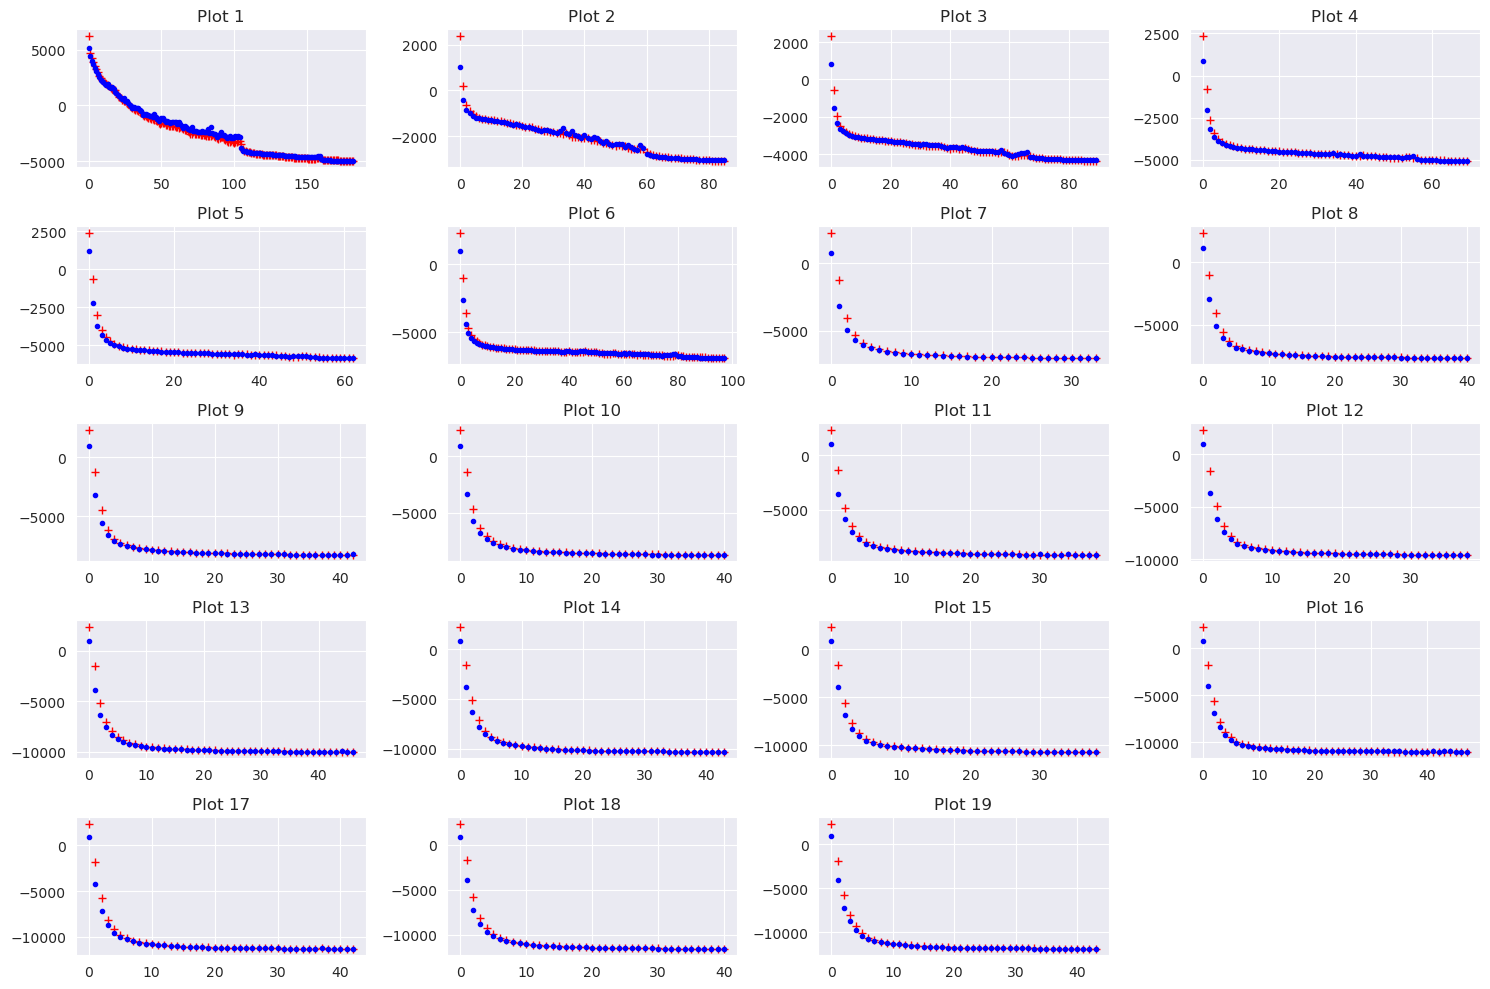

In [16]:
# Set up a grid with 3 rows and 4 columns
fig, axs = plt.subplots(5, 4, figsize=(15, 10))

# Flatten the axes array for easy iteration
axs = axs.flatten()

# Plot each loss value in the grid
for i in range(len(loss_vals)):
    axs[i].plot(np.array(loss_vals[i][0]), 'r+')
    axs[i].plot(np.array(loss_vals[i][1]), 'b.')
    axs[i].set_title(f'Plot {i+1}')

# Hide any empty subplots
for i in range(len(loss_vals), len(axs)):
    fig.delaxes(axs[i])

plt.tight_layout()
plt.show()

In [17]:
# for i in range(len(loss_vals)):
#     plt.figure(i)  # Create a new figure for each plot
#     plt.plot(np.array(loss_vals[i][0]), 'r+')
#     plt.plot(np.array(loss_vals[i][1]), 'b.')
#     plt.show()  # Display the plot

In [18]:
model_path = model_base_path/'hyperparameters.pkl'

with open(model_path, 'wb') as f:
    pickle.dump({'ncomps':ncomps, 'nevecs':nevecs,'nbasecomps':nbasecomps, 'ncauses':ncauses, 'crop_size':crop_size}, f)

In [19]:
loss_vals[0][1]

[5127.371783447265,
 4421.557208251953,
 3997.1665771484377,
 3664.146807861328,
 3364.21022644043,
 3076.0226318359373,
 2781.606640625,
 2502.1103271484376,
 2311.901983642578,
 2185.0351837158205,
 2072.3688934326174,
 1957.2202911376953,
 1860.8739852905273,
 1881.7578903198241,
 1646.8162384033203,
 1535.2476303100586,
 1605.6066329956054,
 1490.3181076049805,
 1228.7000045776367,
 1079.601821899414,
 895.2439735412597,
 881.2574920654297,
 676.5315765380859,
 570.2442001342773,
 646.3970794677734,
 395.8699378967285,
 405.6749126434326,
 184.85182704925538,
 5.341350555419922,
 -37.225593948364256,
 -221.07960357666016,
 -152.6103542327881,
 -247.83912200927733,
 -278.5332206726074,
 -259.8644220352173,
 -452.3914852142334,
 -492.4496885299683,
 -856.8814338684082,
 -732.260334777832,
 -754.6223136901856,
 -902.7610763549804,
 -869.7086082458496,
 -937.9091430664063,
 -987.5744094848633,
 -1038.5281127929688,
 -817.4879737854004,
 -1070.42705078125,
 -1211.264910888672,
 -1382.26